# Part 1
Load the dataset trailers.csv. The dataset represents a diverse col- lection of Hollywood movie trailers accessible via https://archive.org/. Choose one trailer from the dataset you think is interesting to analyze. Download this trailer with the supplied url. [You can also use !wget to get this trailer from the url in Python]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import collections
import wget

In [2]:
path = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Lab Sessions/trailers.csv'
trailers = pd.read_csv(path)

In [3]:
trailers.loc[840]
trailers.loc[840].url

'https://archive.org/download/TheOtherBoleynGirTrailer/TheOtherBoleynGirTrailer.mp4'

In [4]:
!wget https://archive.org/download/TheOtherBoleynGirTrailer/TheOtherBoleynGirTrailer.mp4

--2021-01-14 13:17:19--  https://archive.org/download/TheOtherBoleynGirTrailer/TheOtherBoleynGirTrailer.mp4
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia803206.us.archive.org/19/items/TheOtherBoleynGirTrailer/TheOtherBoleynGirTrailer.mp4 [following]
--2021-01-14 13:17:23--  https://ia803206.us.archive.org/19/items/TheOtherBoleynGirTrailer/TheOtherBoleynGirTrailer.mp4
Resolving ia803206.us.archive.org (ia803206.us.archive.org)... 207.241.234.126
Connecting to ia803206.us.archive.org (ia803206.us.archive.org)|207.241.234.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25333779 (24M) [video/mp4]
Saving to: ‘TheOtherBoleynGirTrailer.mp4.1’

TheOtherBoleynGirTr 100%[===================>]  24.16M   148KB/s    in 4m 8s   

2021-01-14 13:21:33 (99.6 KB/s) - ‘TheOtherBoleynGirTrailer.mp4.1’ saved [25333779/25333779]


Use scenedetect to automatically detect the scenes of this trailer. Set the threshold to 30. How many scenes has it detected? Compare this with a manual inspection of the trailer. Which scenes are missed/counted twice, and why do you think this is?

In [3]:
import cv2
from tqdm import tqdm_notebook

filename = 'TheOtherBoleynGirTrailer.mp4'
cap = cv2.VideoCapture(filename)  

TOTAL_FRAMES = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # total number of frames
SAMPLE = 241

frames = []
for frame in tqdm_notebook(range(SAMPLE)): # CHANGE THIS TO TOTAL_FRAMES IS YOU WANT ALL FRAMES
    cap.set(cv2.CAP_PROP_POS_FRAMES,frame) # loop over all the frames, and get the frame 
    ret, frame = cap.read() # read the frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert it to RGB
    frames.append(frame) # add it to the list

<ipython-input-3-64e4f506cd3c>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for frame in tqdm_notebook(range(SAMPLE)): # CHANGE THIS TO TOTAL_FRAMES IS YOU WANT ALL FRAMES


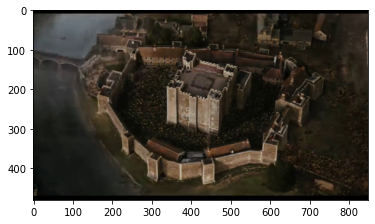

In [6]:
plt.imshow(frames[240])

In [4]:
#Scene detection
from scenedetect import VideoManager
from scenedetect import SceneManager

from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import generate_images

def find_scenes(video_path, threshold=30.0):
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(
        ContentDetector(threshold=threshold))
    base_timecode = video_manager.get_base_timecode()
    video_manager.set_downscale_factor()
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager, show_progress=False)    
    return scene_manager.get_scene_list(base_timecode)

In [6]:
scene_list = find_scenes(filename, threshold=50)
for scene in scene_list:
    print(scene)

(FrameTimecode(frame=0, fps=29.970030), FrameTimecode(frame=46, fps=29.970030))
(FrameTimecode(frame=46, fps=29.970030), FrameTimecode(frame=166, fps=29.970030))
(FrameTimecode(frame=166, fps=29.970030), FrameTimecode(frame=435, fps=29.970030))
(FrameTimecode(frame=435, fps=29.970030), FrameTimecode(frame=507, fps=29.970030))
(FrameTimecode(frame=507, fps=29.970030), FrameTimecode(frame=529, fps=29.970030))
(FrameTimecode(frame=529, fps=29.970030), FrameTimecode(frame=612, fps=29.970030))
(FrameTimecode(frame=612, fps=29.970030), FrameTimecode(frame=699, fps=29.970030))
(FrameTimecode(frame=699, fps=29.970030), FrameTimecode(frame=761, fps=29.970030))
(FrameTimecode(frame=761, fps=29.970030), FrameTimecode(frame=789, fps=29.970030))
(FrameTimecode(frame=789, fps=29.970030), FrameTimecode(frame=806, fps=29.970030))
(FrameTimecode(frame=806, fps=29.970030), FrameTimecode(frame=826, fps=29.970030))
(FrameTimecode(frame=826, fps=29.970030), FrameTimecode(frame=892, fps=29.970030))
(FrameTi

In [7]:
#How many scenes has it detected? I've counted around 80 scenes
#Some black shots are detected as scenes and a lot of rotating cameras from different corners
len(scene_list)

78

In [8]:
#Get a frame the represents a specific scene by getting the middle of the scene. 
cap = cv2.VideoCapture(filename)

frames = []
shot_length = []

for start_time, end_time in scene_list:
    duration = end_time - start_time
    frame = (start_time.get_frames() + int(duration.get_frames() / 2))
    cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
    shot_length.append(duration.get_seconds())

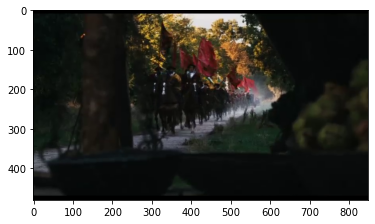

In [9]:
plt.imshow(frames[8]) 

In [10]:
#Save our frames
if not os.path.exists('scenes/'):
    os.mkdir('scenes/')

for i, frame in enumerate(frames):
    cv2.imwrite('scenes/frame_{}.jpg'.format(i), frame)

In [14]:
#Predict one shot for entire list
path_model = '/Users/jaspervogelzang/Downloads/shot_classifier_python38.h5'
model = keras.models.load_model(path_model)

def preprocess_frame(frame, single_batch=False,  color_mode='rgb'):
    frame = cv2.resize(frame, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
    if color_mode == 'grayscale':
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    if single_batch:
        frame = tf.expand_dims(frame, 0)
    return frame

processed_frames = [preprocess_frame(frame) for frame in frames]
processed_frames = np.array(processed_frames)
data = tf.data.Dataset.from_tensor_slices(processed_frames).batch(64)

probabilities = model.predict(data, verbose=1)
labels = ['CS', 'ECS', 'FS', 'LS', 'MS']

image_classes = np.argmax(probabilities, axis=1)
image_labels = [labels[image_class] for image_class in image_classes]
print(image_labels)

2/2 [==============================] - 1s 450ms/step
['FS', 'LS', 'MS', 'FS', 'CS', 'FS', 'CS', 'FS', 'FS', 'MS', 'CS', 'MS', 'FS', 'MS', 'CS', 'MS', 'FS', 'CS', 'CS', 'CS', 'CS', 'CS', 'FS', 'CS', 'FS', 'FS', 'CS', 'FS', 'CS', 'LS', 'FS', 'CS', 'FS', 'CS', 'CS', 'ECS', 'LS', 'CS', 'CS', 'CS', 'ECS', 'CS', 'FS', 'FS', 'CS', 'CS', 'CS', 'FS', 'MS', 'LS', 'CS', 'CS', 'CS', 'CS', 'FS', 'CS', 'ECS', 'CS', 'FS', 'MS', 'CS', 'MS', 'FS', 'FS', 'LS', 'CS', 'CS', 'CS', 'CS', 'MS', 'ECS', 'CS', 'FS', 'CS', 'CS', 'FS', 'LS', 'ECS']


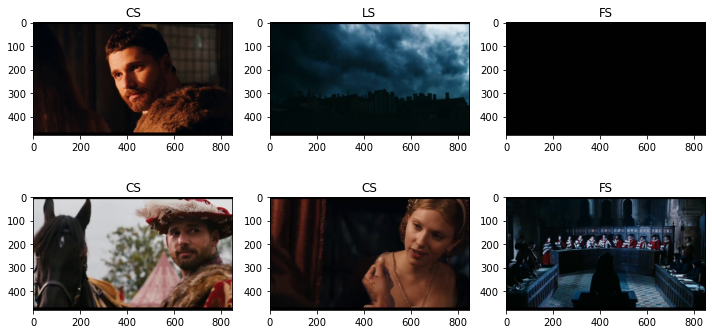

In [181]:
#Plot six random scenes with their classification
random_indices = np.random.choice(range(len(image_classes)), 
                                  size=6, replace=False)

frames_sample = np.array(frames)[random_indices]
classes_sample = np.array(image_labels)[random_indices]

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frames_sample[i])
    ax.set_title(classes_sample[i])
plt.tight_layout()

In [200]:
#Output results and compare with own classification
df_path = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Lab Sessions/classified.csv'
df = pd.read_csv(df_path)
classification = pd.DataFrame()
classification['video'] = [filename for i in range(len(frames))]
classification['shot'] = range(len(frames))
classification['shot_length'] = shot_length
classification['one_shot'] = image_labels
classification = pd.merge(classification, df, how='right', on='shot')
classification['same'] = classification['one_shot'] == classification['manually']
classification

,video,shot,shot_length,one_shot,manually,same
0,TheOtherBoleynGirTrailer.mp4,0,1.534867,FS,LS,False
1,TheOtherBoleynGirTrailer.mp4,1,4.004000,LS,LS,True
2,TheOtherBoleynGirTrailer.mp4,2,8.975633,MS,FFS,False
3,TheOtherBoleynGirTrailer.mp4,3,2.402400,FS,LS,False
4,TheOtherBoleynGirTrailer.mp4,4,0.734067,CS,CS,True
...,...,...,...,...,...,...
73,TheOtherBoleynGirTrailer.mp4,73,1.001000,CS,CS,True
74,TheOtherBoleynGirTrailer.mp4,74,1.501500,CS,MS,False
75,TheOtherBoleynGirTrailer.mp4,75,2.102100,FS,LS,False
76,TheOtherBoleynGirTrailer.mp4,76,3.003000,LS,MS,False


In [198]:
#Count the number of correctly classified shots
#Better than random but not enterily correct
collections.Counter(classification['same'])

Counter({False: 46, True: 32})

# Part 2
Make three subset of the dataframe: one of movies published between 1920-1940, one of movies released between 1960-1980 and a final one of movies published between 2000-2020. Get a random sample (using df.sample(N)) of 5 to 10 videos for each period (downloading them could take a while).

For each subset, download the videos in the subset using with the urls provided. Make sure to keep track of where your videos are downloaded to. With the Python module wget, for example, you can use:


In [11]:
path = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Lab Sessions/trailers.csv'
trailers = pd.read_csv(path)

early = trailers.loc[(trailers['year'] >= 1920) & (trailers['year'] <= 1940)]
mid = trailers.loc[(trailers['year'] >= 1960) & (trailers['year'] <= 1980)]
late = trailers.loc[(trailers['year'] >= 2000) & (trailers['year'] <= 2020)]

In [213]:
#Subset by random sample
early_sample = early.sample(5)
mid_sample = mid.sample(5)
late_sample = late.sample(5)

In [221]:
if not os.path.exists('videos/'): 
    os.mkdir('videos/')

video_paths = []
for video in tqdm(early_sample.itertuples(), total=len(early_sample)):
    video_url = video.url
    output_path = 'videos/' + video.trailer_title + '.mp4' 
    filename = wget.download(video_url , out=output_path) 
    video_paths.append(output_path)

In [14]:
def dl_sample(df, folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
    
    video_paths = []
    for video in tqdm(df.itertuples(), total=len(df)):
        video_url = video.url
        output_path = folder + video.trailer_title + '.mp4'
        filename = wget.download(video_url, out=output_path)
        video_paths.append(output_path)
        
    return video_paths

trailer1920 = dl_sample(early_sample, 'early/')
trailer1960 = dl_sample(mid_sample, 'mid/')
trailer2000 = dl_sample(late_sample, 'late/')

NameError: name 'early_sample' is not defined

In [12]:
#Load the paths of downloaded videos, if session has been terminated
folder20 = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Exam/Exam 2/early/'
folder60 = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Exam/Exam 2/mid/'
folder00 = '/Users/jaspervogelzang/Documents/ADS Master/Data Mining/Exam/Exam 2/late/'

def load_path(d):
    loc = []
    for path in os.listdir(d):
        full_path = os.path.join(d, path)
        loc.append(full_path)
    return loc

trailer1920 = load_path(folder20)
trailer1960 = load_path(folder60)
trailer2000 = load_path(folder00)

For each subset, loop over all video paths, and use the function you created in 1.5 to process the videos. Add the dataframes for each video in a subset to list, so you end up with a list of dataframes. You can concatenate this list of dataframes using pd.concat(list of dfs).

In [15]:
def process_video(filename, model = model, labels = labels):
    # create list of scenes
    scene_list = find_scenes(filename, threshold=30)
    
    # get frame info
    cap = cv2.VideoCapture(filename)
    
    frames = []
    shot_length = []

    for start_time, end_time in scene_list:
        duration = end_time - start_time
        frame = (start_time.get_frames() + int(duration.get_frames() / 2))
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        shot_length.append(duration.get_seconds())
    
    # preprocess frames
    processed_frames = [preprocess_frame(frame) for frame in frames]
    processed_frames = np.array(processed_frames)
    data = tf.data.Dataset.from_tensor_slices(processed_frames).batch(64)
    
    # predict labels
    probabilities = model.predict(data, verbose=1)
    image_classes = np.argmax(probabilities, axis=1)
    image_labels = [labels[image_class] for image_class in image_classes]
    
    # create dataframe
    df = pd.DataFrame()
    df['video'] = [filename for i in range(len(frames))]
    df['shot'] = range(len(frames))
    df['shot_length'] = shot_length
    df['shot_type'] = image_labels
    
    return df

In [16]:
def analyze_trailers(videos):
    dfs = []
    for vid in videos:
        dfs.append(process_video(vid))
    return pd.concat(dfs)

In [17]:
early_shots = analyze_trailers(trailer1920)
mid_shots = analyze_trailers(trailer1960)
late_shots = analyze_trailers(trailer2000)

2/2 [==============================] - 1s 266ms/step


In [240]:
def get_statistics(df):
    print('mean shot length:', df.shot.mean())
    print('shot length stdev:', df.shot.std())
    display(df.shot_type.value_counts() / df.shot_type.value_counts().sum())
    
get_statistics(early_shots)
get_statistics(mid_shots)
get_statistics(late_shots)

mean shot length: 19.128440366972477
shot length stdev: 14.07065564651484


FS     0.422018
ECS    0.238532
MS     0.183486
CS     0.110092
LS     0.045872
Name: shot_type, dtype: float64

mean shot length: 16.676470588235293
shot length stdev: 14.049423610071747


FS     0.426471
MS     0.191176
CS     0.147059
LS     0.132353
ECS    0.102941
Name: shot_type, dtype: float64

mean shot length: 43.62908011869436
shot length stdev: 29.04925184548222


MS     0.299703
FS     0.261128
CS     0.216617
ECS    0.148368
LS     0.074184
Name: shot_type, dtype: float64